# Lab 6b: Multiple models & Ensemble Learning 

## Outline
- Introduction
 - Voting Methods 
- Ensemble Learning 
    - Bagging
        - Random Forest
    - Boosting
        - AdaBoost
        - GradientBoost
    


## Introduction
In most areas, having multiple experts work on a problem often leads to a better solution.  The same idea can be applied to Machine Learning,  where the experts are different _estimators_ (e.g., classifiers, regressors, neural nets).  As in the real world, if the estimators "have different perspectives", their combination will have improved generalizability and robustness over any single one of them.

Run the code below to see an example of combining the results of a three different classifiers. 
Each classifier is trained on two features of the Iris dataset.

In [ ]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=10)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting="hard", weights=[2, 1, 1])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
def plot_clf(plt, clf, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))
for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Combination']):
    plot_clf(axarr[idx[0], idx[1]], clf,X,y)
    axarr[idx[0], idx[1]].set_title(tt)
    
plt.show()

### Combining Estimators / Voting
In the above example, *voting* to used to determine the output of the combined classifier.

In majority *voting*, the predicted class label for a particular sample is the class label that represents the majority (mode) of the labels predicted by each individual classifier.
E.g., if the predictions for a given sample are
* classifier 1 -> label A
* classifier 2 -> label A
* classifier 3 -> label B  
the combined prediction is “label A”.

Weights can also be applied to make some classifiers votes count more than others. 

Many classifiers, when given a set of features, also generate estimates of the probability of each possible label being present.  These can be probabilities can be combined to form more nuanced predictions.  

One approach to this is via an approach called _soft voting_. The idea is to return the class label as argmax of the sum of predicted probabilities. Here again, weights can be be assigned to each classifier in order to favor more accurate ones (i.e. weight their estimates more heavily in the final outcome).

To illustrate this with a simple example, let’s assume we have 3 classifiers and a 3-class classification problem with class labels A,B,C, using weights $w_1$, $w_2$, and $w_3$. If for a given sample, the following class label probabilities were found:


 classifier i | P_i(A) | P_i(B) | P_i(C) 
 -------------|:------------:|:------------:|:-----------:  
 classifier 1 |  0.2  | 0.5 | 0.3
 classifier 2 |  0.6  | 0.3 | 0.1
 classifier 3 |  0.3  | 0.4 | 0
  

The corresponding soft vote, S, for class k is given by
$S(k) = w_1 P_1(k)+w_2 P_2(k) + w_3 P_3(k)$. If we assign equal weights of 1 to all classifiers, in the example above

 | S(A) | S(B) | S(C)
-|------|------|----- 
S(k) |1.1 | 1.2 | 0.4

Here, the predicted class label is B, since it has the highest soft vote.

## Task: Hard and Soft Voting
1. In general, when using soft max voting with n classifiers, if one uses a uniform weighting of 1/n, do the soft voting scores define a probability measure on possible class labels?

2. What label would be selected as the output for each classifier in the table above?  
Using a majority voting, what class label would be selected using these outputs?

3. The [sklearn.ensemble.VotingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) 
allows one to perform both majority (hard) voting and soft vote class with a collection of individual classifiers.
The `voting` parameter selects the method to use. Re-run the code above by changing the `voting` parameter from `"hard"` to `"soft"`.  
Does it look like the combined classifier results improve, stay the same or get worse? Explain your reasoning.

Put your answers below.

Below is a [sklearn label probability example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_probas.html#sphx-glr-auto-examples-ensemble-plot-voting-probas-py);  It shows the label probabilities from with three different base classifiers and a voting classifier for one data point.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression(random_state=123)
clf2 = RandomForestClassifier(random_state=123)
clf3 = GaussianNB()
X = np.array([[-1.0, -1.0], [-1.2, -1.4], [-3.4, -2.2], [1.1, 1.2]])
y = np.array([1, 1, 2, 2])

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                        voting='soft',
                        weights=[2, 1, 1])

# predict class probabilities for all classifiers
probas = [c.fit(X, y).predict_proba(X) for c in (clf1, clf2, clf3, eclf)]

# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]


# plotting

N = 4  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-3
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), width,
            color='green', edgecolor='k')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width,
            color='lightgreen', edgecolor='k')

# bars for VotingClassifier
p3 = ax.bar(ind, [0, 0, 0, class1_1[-1]], width,
            color='blue', edgecolor='k')
p4 = ax.bar(ind + width, [0, 0, 0, class2_1[-1]], width,
            color='steelblue', edgecolor='k')

# plot annotations
plt.axvline(2.8, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
ax.set_xticklabels(['LogisticRegression\nweight 1',
                    'GaussianNB\nweight 1',
                    'RandomForestClassifier\nweight 5',
                    'VotingClassifier\n(average probabilities)'],
                   rotation=40,
                   ha='right')
plt.ylim([0, 1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper left')
plt.show()

## Hyper-parameter optimization 
Independently optimizing each estimator before combining it with others is a good first step, but given it's their combined performance that is of interest, simultaneously optimizing all their hyper-parameters may yield additional improvements.  

Below is an simultaneous optimization using on sklearn.GridSearchCV, in the example, voting strategies are also explored.

More detailed examples involving pipeline optimization, including feature selection can be found in this [MLxtend] article](http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/) on Sebastian Raschka's `EnsembleVoteClassifier` (which became the basis for the `scikit-learn.VotingClassifier`).  See the pipeline and feature documentation at sklearn as well.

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV
clf1 = DecisionTreeClassifier()
clf2 = KNeighborsClassifier()
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)])

params = {'dt__max_depth': [3, 4, 5],
          'knn__n_neighbors': [6, 7, 8],
          'voting': ['hard','soft']}
          
grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5, scoring = 'accuracy')

X = iris.data[:, [0, 2]]
y = iris.target
grid.fit(X, y)

def report_results(grid):
    cv_keys = ('mean_test_score', 'std_test_score', 'params')
    print('mean_test_score +/ std_test_score, {params}') 
    for r, _ in enumerate(grid.cv_results_['mean_test_score']):
        bf = '*' if grid.cv_results_[cv_keys[0]][r]==grid.best_score_ else ' '
        print(bf+"%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

report_results(grid)

## Task: Working with GridSearchCV
Using the code block below, determine the best model found by `GridSearchCV` and then do the following:
1. Print out the best model's average accuracy score on out of fold data. 
2. Print out the best model's parameters.
3. Use `plot_clf` to display its decision boundaries.

hint: This information is available in `grid` variable that was computed in the previous cell.

In [ ]:
### BEGIN SOLUTION
print('Best accuracy =', grid.best_score_)
print('Best parameters =',  grid.best_params_)

plot_clf(plt, grid, X, y)
plt.show()
### END SOLUTION

## Ensemble Methods
The goal of **ensemble methods** is to _automatically create_ the set of 
base estimators (using the method's learning algorithm) which are then combined 
using a voting approach.  

Two families of ensemble methods are usually distinguished:
- In **averaging methods**, the driving principle is to build several estimators 
independently and then to average their predictions. On average, the combined 
estimator is usually better than any of the single base estimator because 
its variance is reduced. **Examples:** 
  - [Bagging methods](http://scikit-learn.org/stable/modules/ensemble.html#bagging), 
  - [Forests of randomized trees](http://scikit-learn.org/stable/modules/ensemble.html#forest)

- By contrast, in **boosting methods**, base estimators are built sequentially 
and in order to try to reduce the bias of previously constructed estimators.
Here again, the motivation is to combine several weak models to produce a powerful ensemble. **Examples:** 
  - [AdaBoost](http://scikit-learn.org/stable/modules/ensemble.html#adaboost)
  - [Gradient Tree Boosting](http://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting), … 

### Bagging

Bagging is a powerful method to improve the performance of simple models and reduce overfitting of more complex models. With bagging, several models are fitted on different samples (with replacement) of the population. Then, these models are aggregated by using their average, weighted average or a voting system.

A key insight for bagging is that by averaging (or generally aggregating) many low bias, high variance models, we can reduce the variance while retaining the low bias. Here’s an example of this for density estimation:

<img src="https://qph.ec.quoracdn.net/main-qimg-55c44d63831742ddd387541a428fcedf.webp">

Each estimate is centered around the true density, but is overly complicated (low bias, high variance). By averaging them out, we get a smoothed version of them (low variance), still centered around the true density (low bias). (Jonathan Gordon on Quora)

#### Random Forests

A random forest is a variant of bagging which results in a more random but potentially more powerful classifier. While training our individual decision trees, we randomly select a subset of features to choose our best splits from. This makes the base decision trees more different from one another.

To summaryize, additional random variable selection is introduced in random forests to make the underlying trees even more independent, which makes it perform better than ordinary bagging.

Here is an example of a random forest in sklearn converted into a standard bagging classifier without randomized best splits.


In [ ]:
from sklearn.ensemble import RandomForestClassifier 

clf = RandomForestClassifier(n_estimators=20, max_features=None) # no randomized splitting
clf.fit(X, y)

### Boosting 

Boosting is a general ensemble method that creates a stronger model from a number of weaker models.

This is done by building a model from the training data, then creating a second model that attempts to correct the errors from the first model. Models are added until the training set is predicted perfectly or a maximum number of models are added.

#### Adaptive Boosting (AdaBoost)

The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on weighted versions of the data. As iterations proceed, examples that are difficult to predict receive ever-increasing influence.

### An Example

<img src="images/boosting1.png" style="width:600px;">

(1) We start with one [decision tree stump](https://en.wikipedia.org/wiki/Decision_stump) to classify training samples.  
(2) In the next round, we then train another decision tree stump that focuses on getting the samples that were misclassified in (1). We achieve this by putting a larger weight on the previously misclassified training samples.  
(3) The 2nd classifier will likely get some other samples wrong, so we would re-adjust the weights and train the third classifier accordingly.  
(4) Same logic from (3) is applied.


In a nutshell, we can summarize “Adaboost” as “adaptive” or “incremental” learning from mistakes. Eventually, we will come up with a model that has a lower bias than an individual decision tree (thus, it is less likely to underfit the training data).

#### Gradient Boosting

Gradient Boosting is just another popular boosting technique that is very similar to Adaptive Boosting.  
The major difference is that Gradient Boosting identifies the ‘shortcomings’ of weaker learners by gradients in the loss function instead of the alpha weights performance in Adaptive Boosting.


## scikit-learn Ensemble Methods
You will now use the sci-kit to setup and run ensemble method optimizations using the techniques introduced earlier. Understanding the useful model parameters associated with a these powerful classification approaches takes time and practice, and as with all classification approaches, what works well will be problem domain or even data set specific.  

Please run the code below to create and display a blob data set.

In [ ]:
from itertools import cycle
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=20, random_state=42)
y = y % 2
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k'); plt.show()

## Task: Ensemble training
Read the hyper-linked documentation and build models on the  blob dataset (X, y) using the following approaches:

(1) RandomForestClassifier  
(2) BaggingClassifier  
(3) AdaBoostClassifier  
(4) GradientBoostingClassifier  

Below is a fully worked example for building a *DecisionTreeClassifier* on the blob dataset.  

** [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) **  

In [ ]:
from sklearn.tree import DecisionTreeClassifier 

# Step 1) Display an example
clf = DecisionTreeClassifier(max_depth=4)

clf.fit(X, y)
plot_clf(plt, clf, X, y)
plt.show()

# Step 2) Pick parameters to optimize
params = {'max_depth': [2, 4, 8, 16], 'min_samples_leaf':[2, 4, 8]}

DTgrid = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring = 'accuracy')
DTgrid.fit(X,y)
plot_clf(plt, DTgrid, X, y); plt.show()
report_results(DTgrid) # Show Results

** [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) **  
List of hyperparameters to tune: (max_features, n_estimators, min_sample_leaf)

In [ ]:
from sklearn.ensemble import RandomForestClassifier 

# Step 1) Display an example
### BEGIN SOLUTION
clf = DecisionTreeClassifier(max_depth=4)
### END SOLUTION

clf.fit(X, y)
plot_clf(plt, clf, X, y); plt.show()

# Step 2) Pick parameters to optimize
### BEGIN SOLUTION
params = {'max_depth': [2, 4, 8, 16], 'min_samples_leaf':[2, 4, 8]}
### END SOLUTION

RFgrid = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring = 'accuracy')
RFgrid.fit(X,y)
plot_clf(plt, RFgrid, X, y); plt.show()
report_results(RFgrid) # Show Results

** [BaggingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) **  
List of hyperparameters to tune: (base_estimator, max_features, n_estimators)

In [ ]:
from sklearn.ensemble import BaggingClassifier

# Step 1) Display an example
### BEGIN SOLUTION
clf = BaggingClassifier(n_estimators=4)
### END SOLUTION

clf.fit(X, y)
plot_clf(plt, clf, X, y); plt.show()

# Step 2) Pick parameters to optimize
### BEGIN SOLUTION
params = {'n_estimators': [2, 4, 8, 16]}
### END SOLUTION

BCgrid = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring = 'accuracy')
BCgrid.fit(X,y)
plot_clf(plt, BCgrid, X, y); plt.show()
report_results(BCgrid) # Show Results

** [AdaBoostClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) **  
List of hyperparameters to tune: (base_estimator, n_estimators, learning_rate)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Step 1) Display an example
### BEGIN SOLUTION
clf = AdaBoostClassifier(n_estimators=4)
### END SOLUTION

clf.fit(X, y)
plot_clf(plt, clf, X, y); plt.show()

# Step 2) Pick parameters to optimize
### BEGIN SOLUTION
params = {'n_estimators':[2, 3, 4, 5, 6]}
### END SOLUTION

ABgrid = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring = 'accuracy')
ABgrid.fit(X,y)
plot_clf(plt, grid, X, y); plt.show()
report_results(ABgrid) # Show Results

** [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) **  
List of hyperparameters to tune: (max_depth, n_estimators, learning_rate)

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

# Step 1) Display an example
### BEGIN SOLUTION
clf = GradientBoostingClassifier(max_depth=4)
### END SOLUTION

clf.fit(X, y)
plot_clf(plt, clf, X, y); plt.show()

# Step 2) Pick parameters to optimize
### BEGIN SOLUTION
params = {'max_depth': [2, 3, 4], 'min_samples_leaf':[2, 4, 8]}
### END SOLUTION

GBgrid = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring = 'accuracy')
GBgrid.fit(X,y)
plot_clf(plt, GBgrid, X, y); plt.show()
report_results(GBgrid) # Show Results

## Task: Ensemble your ensemble methods
Combine your best ensemble classifiers using the `VoteClassifier` approach described in the Introduction.

hint: use a copy of the final `grid` variable from each of your optimizations.

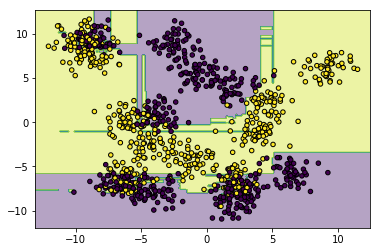

mean_test_score =  0.83
std_test_score =  0.0314642654451


In [12]:
### BEGIN SOLUTION
clf = VotingClassifier(estimators=[('RF', RFgrid), ('BC', BCgrid), ('AB', ABgrid), ('GB', GBgrid)],
                        voting='soft')

### END SOLUTION
clf.fit(X,y)
plot_clf(plt, clf, X, y); plt.show()
ac = cross_val_score(clf, X, y, cv=5, scoring = 'accuracy')
print('mean_test_score = ', ac.mean())
print('std_test_score = ', ac.std())

## Task: Learn hyper-hyper-parameters (Homework)
You setup `GridSearchCV` to simultaneously tune some of individual classifier parameters as well explore "hard" and "soft" voting.  In order to reduce the amount of time it takes to do this, you should restrict the size of the space you search using only a small number values for each parameter. Alternatively you can search to using randomized grid search.

hints: 
1. Use the setup in the Introduction
2. Create your set of parameters to optimize by recoding a subset of optimization parameters you used above and also including voting options.

In [13]:
### BEGIN SOLUTION

### END SOLUTION

## Task: Understand Ensemble Method Concepts

Below are 6 questions on ensemble methods. Refer the the scikit-learn user guide's section on ensemble methods to help you answer these questions.

1. Bagging maintains the variance of the base model while lowering bias. (T/F)
2. Predicting with gradient boosted model is slower than predicting with a decision tree. (T/F)
3. To make a random forest, you may generate hundreds of trees and then aggregate the results of these tree. Which of the following are true about individual trees in Random Forest? Select all that apply.

  (A) Individual trees find best splits on a subset of the features
  (B) Individual trees find best splits on all of the features
  (C) Individual trees find best splits on a subset of observations
  (D) Individual trees find best splits on all of the observations
4. Which of the following are true about the “max_depth” hyperparameter in GradientBoostedRegressor and GradientBoostedClassifier? Select all that apply. (A) Lower is better parameter in case of same validation accuracy
  (B) Higher is better parameter in case of same validation accuracy
  (C) Increase the value of max_depth may overfit the data
  (D) Increase the value of max_depth may underfit the data
5. For boosting, why is it suggested that the base model be "weak"?
6. Do bagging and boosting methods always improve model accuracy? When is not an appropriate situation to use ensemble learning methods?

## Summary
Credit: 
Some advantages of decision trees are:

- Simple to understand and to interpret. Trees can be visualised.
- Requires little data preparation. Other techniques often require data normalisation, dummy variables need to be created and blank values to be removed. Note however that this module does not support missing values.
- The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.
- Able to handle both numerical and categorical data. Other techniques are usually specialised in analysing datasets that have only one type of variable. See [algorithms](http://scikit-learn.org/stable/modules/tree.html#tree-algorithms) for more information.
- Able to handle multi-output problems.
- Uses a white box model. If a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic. By contrast, in a black box model (e.g., in an artificial neural network), results may be more difficult to interpret.
- Possible to validate a model using statistical tests. That makes it possible to account for the reliability of the model.
- Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.

The disadvantages of decision trees include:

- Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning (not currently supported), setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.
- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.
- The problem of learning an optimal decision tree is known to be NP-complete under several aspects of optimality and even for simple concepts. Consequently, practical decision-tree learning algorithms are based on heuristic algorithms such as the greedy algorithm where locally optimal decisions are made at each node. Such algorithms cannot guarantee to return the globally optimal decision tree. This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement.
- There are concepts that are hard to learn because decision trees do not express them easily, such as XOR, parity or multiplexer problems.
- Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.

Credit: Much of the content and support code from this lab is based on material from scikit-learn's wonderful on-line documentation. Reading through it's tutorial and introductory material while playing with the examples provided, and creating your own is a great way to learn more about Machine Learning.